# Task-5 Decision Tree Implementation

## Question 2

Q2. Generate your dataset using the given lines of code.

a) Show the usage of *your decision tree* on the above dataset. The first 70% of the data should be used for training purposes and the remaining 30% for test purposes. Show the accuracy, per-class precision and recall of the decision tree you implemented on the test dataset.

b) Use 5 fold cross-validation on the dataset. Using nested cross-validation find the optimum depth of the tree.

> You should be editing `classification-exp.py` for the code containing the above experiments.

### The complete code is also available in `classification-exp.py`

### Importing required libraries

In [2]:
import sys
import os

# Add the path to the directory containing tree.py
sys.path.append(os.path.abspath("../"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *

np.random.seed(42)

In [4]:
from latexify import latexify, format_axes
latexify()

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Creating dataset using the code provided

Shape of X: (100, 2)
Shape of y: (100,)


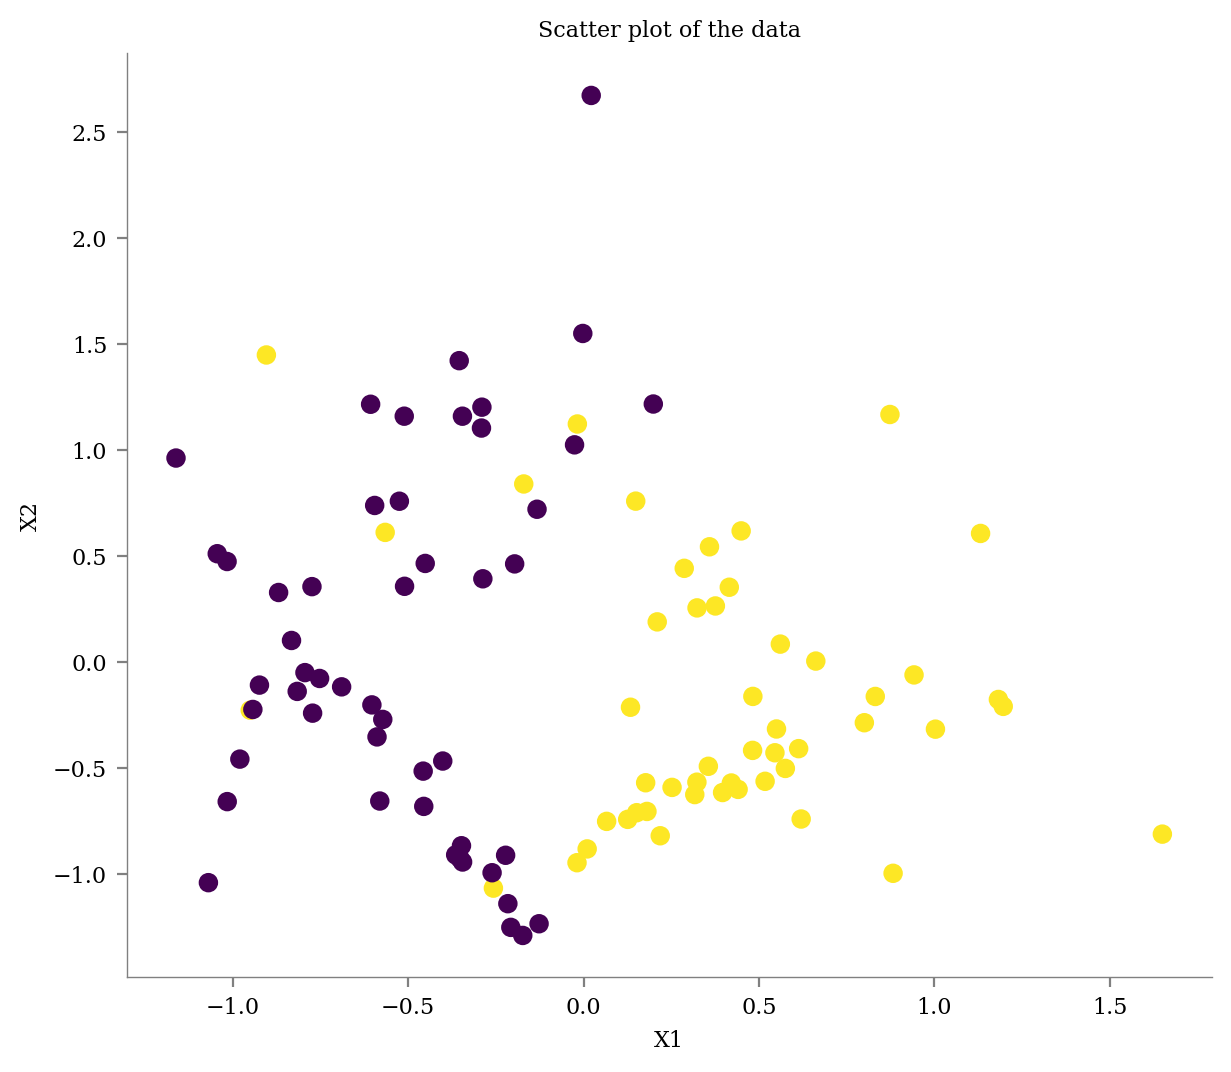

In [8]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# For plotting
plt.figure(figsize=(7, 6))
plt.title('Scatter plot of the data')
plt.scatter(X[:, 0], X[:, 1], c=y)
format_axes(plt.gca())
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


### a) Show the usage of *your decision tree* on the above dataset. The first 70% of the data should be used for training purposes and the remaining 30% for test purposes. Show the accuracy, per-class precision and recall of the decision tree you implemented on the test dataset.



#### Splitting the data into training and testing data

In [9]:
X = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
y = pd.Series(y)

split = int(0.7 * X.shape[0])
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (70, 2)
Shape of X_test: (30, 2)
Shape of y_train: (70,)
Shape of y_test: (30,)


#### Using my decision tree to train and predict data

In [10]:
# Training the model
model = DecisionTree(criterion='information_gain', max_depth=5)
model.fit(X_train, y_train)

# Predicting the values
y_pred = model.predict(X_test)

print("Criteria :", "Information Gain")
print("Accuracy :", np.round(accuracy(y_test, y_pred),4))
for cls in np.unique(y_test):
    print(f"Precision for class {cls} :", np.round(precision(y_test, y_pred, cls),4))
    print(f"Recall for class {cls} :", np.round(recall(y_test, y_pred, cls),4))

Criteria : Information Gain
Accuracy : 0.8667
Precision for class 0 : 0.75
Recall for class 0 : 0.9
Precision for class 1 : 0.9444
Recall for class 1 : 0.85


### b) Use 5 fold cross-validation on the dataset. Using nested cross-validation find the optimum depth of the tree.

#### KFold Cross Validation

In [11]:
num_folds = 5
fold_size = X.shape[0] // num_folds

accuracies = []

for i in range(num_folds):
    start = i * fold_size
    end = (i + 1) * fold_size

    X_test = X.iloc[start:end]
    y_test = y.iloc[start:end]

    X_train = pd.concat([X.iloc[:start], X.iloc[end:]])
    y_train = pd.concat([y.iloc[:start], y.iloc[end:]])

    dt_classifier = DecisionTree(criterion='information_gain', max_depth=5)
    dt_classifier.fit(X_train, y_train)

    y_pred = dt_classifier.predict(X_test)
    
    fold_accuracy = accuracy(y_test, y_pred)
    print(f"Fold {i} Accuracy : {np.round(fold_accuracy, 4)}")
    accuracies.append(fold_accuracy)

print("\nMean Accuracy :", np.round(np.mean(accuracies), 4))

Fold 0 Accuracy : 0.8
Fold 1 Accuracy : 0.9
Fold 2 Accuracy : 0.85
Fold 3 Accuracy : 0.8
Fold 4 Accuracy : 0.95

Mean Accuracy : 0.86


#### Nested Cross Validation

Reference: [Nipun Sir](https://nipunbatra.github.io/ml-teaching/notebooks/hyperparams-experiments.html)

In [12]:
# Using library this time for KFold division because manual implementation done in previos cell.
from sklearn.model_selection import KFold
from itertools import product

hyperparameters = dict()
hyperparameters['max_depth'] = [1,2,3,4,5,6,7,8,9,10]
hyperparameters['criteria_values'] = ['information_gain', 'gini_index']

num_outer_folds = 5
num_inner_folds = 5

kf_outer = KFold(n_splits=num_outer_folds, shuffle=False)
kf_inner = KFold(n_splits=num_inner_folds, shuffle=False)

outer_loop_accuracies = []
inner_loop_accuracies = []

results= {}
outer_count = 0
overall_count = 0

for outer_train_index, outer_test_index in kf_outer.split(X):
    # Split the data into outer training and test sets
    X_outer_train, X_outer_test = X.iloc[outer_train_index], X.iloc[outer_test_index]
    y_outer_train, y_outer_test = y.iloc[outer_train_index], y.iloc[outer_test_index]
    
    
    inner_count = 0
    
    for innner_train_index, inner_test_index in kf_inner.split(X_outer_train):
        print("Outer Fold {}, Inner Fold {}".format(outer_count+1, inner_count+1))
        # Split the data into inner training and test sets
        X_inner_train, X_inner_test = X_outer_train.iloc[innner_train_index], X_outer_train.iloc[inner_test_index]
        y_inner_train, y_inner_test = y_outer_train.iloc[innner_train_index], y_outer_train.iloc[inner_test_index]
        
        for max_depth, criterion in product(hyperparameters['max_depth'],
                                                               hyperparameters['criteria_values']):
            
            # Initialize and train the model with the current hyperparameters
            dt_classifier = DecisionTree(max_depth=max_depth, criterion=criterion)
            dt_classifier.fit(X_inner_train, y_inner_train)
            
            # Evaluate the model on the inner test set
            y_inner_test_pred = dt_classifier.predict(X_inner_test)
            val_accuracy = accuracy(y_inner_test_pred, y_inner_test)
            
            results[overall_count] = {'outer_fold': outer_count, 
                                      'inner_fold': inner_count, 
                                      'max_depth': max_depth,  
                                      'criterion': criterion, 
                                      'val_accuracy': val_accuracy}
            overall_count += 1
        inner_count += 1
    outer_count += 1

Outer Fold 1, Inner Fold 1
Outer Fold 1, Inner Fold 2
Outer Fold 1, Inner Fold 3
Outer Fold 1, Inner Fold 4
Outer Fold 1, Inner Fold 5
Outer Fold 2, Inner Fold 1
Outer Fold 2, Inner Fold 2
Outer Fold 2, Inner Fold 3
Outer Fold 2, Inner Fold 4
Outer Fold 2, Inner Fold 5
Outer Fold 3, Inner Fold 1
Outer Fold 3, Inner Fold 2
Outer Fold 3, Inner Fold 3
Outer Fold 3, Inner Fold 4
Outer Fold 3, Inner Fold 5
Outer Fold 4, Inner Fold 1
Outer Fold 4, Inner Fold 2
Outer Fold 4, Inner Fold 3
Outer Fold 4, Inner Fold 4
Outer Fold 4, Inner Fold 5
Outer Fold 5, Inner Fold 1
Outer Fold 5, Inner Fold 2
Outer Fold 5, Inner Fold 3
Outer Fold 5, Inner Fold 4
Outer Fold 5, Inner Fold 5


In [13]:
overall_results = pd.DataFrame(results).T
overall_results

,outer_fold,inner_fold,max_depth,criterion,val_accuracy
0,0,0,1,information_gain,0.8125
1,0,0,1,gini_index,0.8125
2,0,0,2,information_gain,0.9375
3,0,0,2,gini_index,0.9375
4,0,0,3,information_gain,0.9375
...,...,...,...,...,...
495,4,4,8,gini_index,0.6875
496,4,4,9,information_gain,0.6875
497,4,4,9,gini_index,0.6875
498,4,4,10,information_gain,0.6875


#### Plotting the outer fold accuracies vs depth for each outer fold


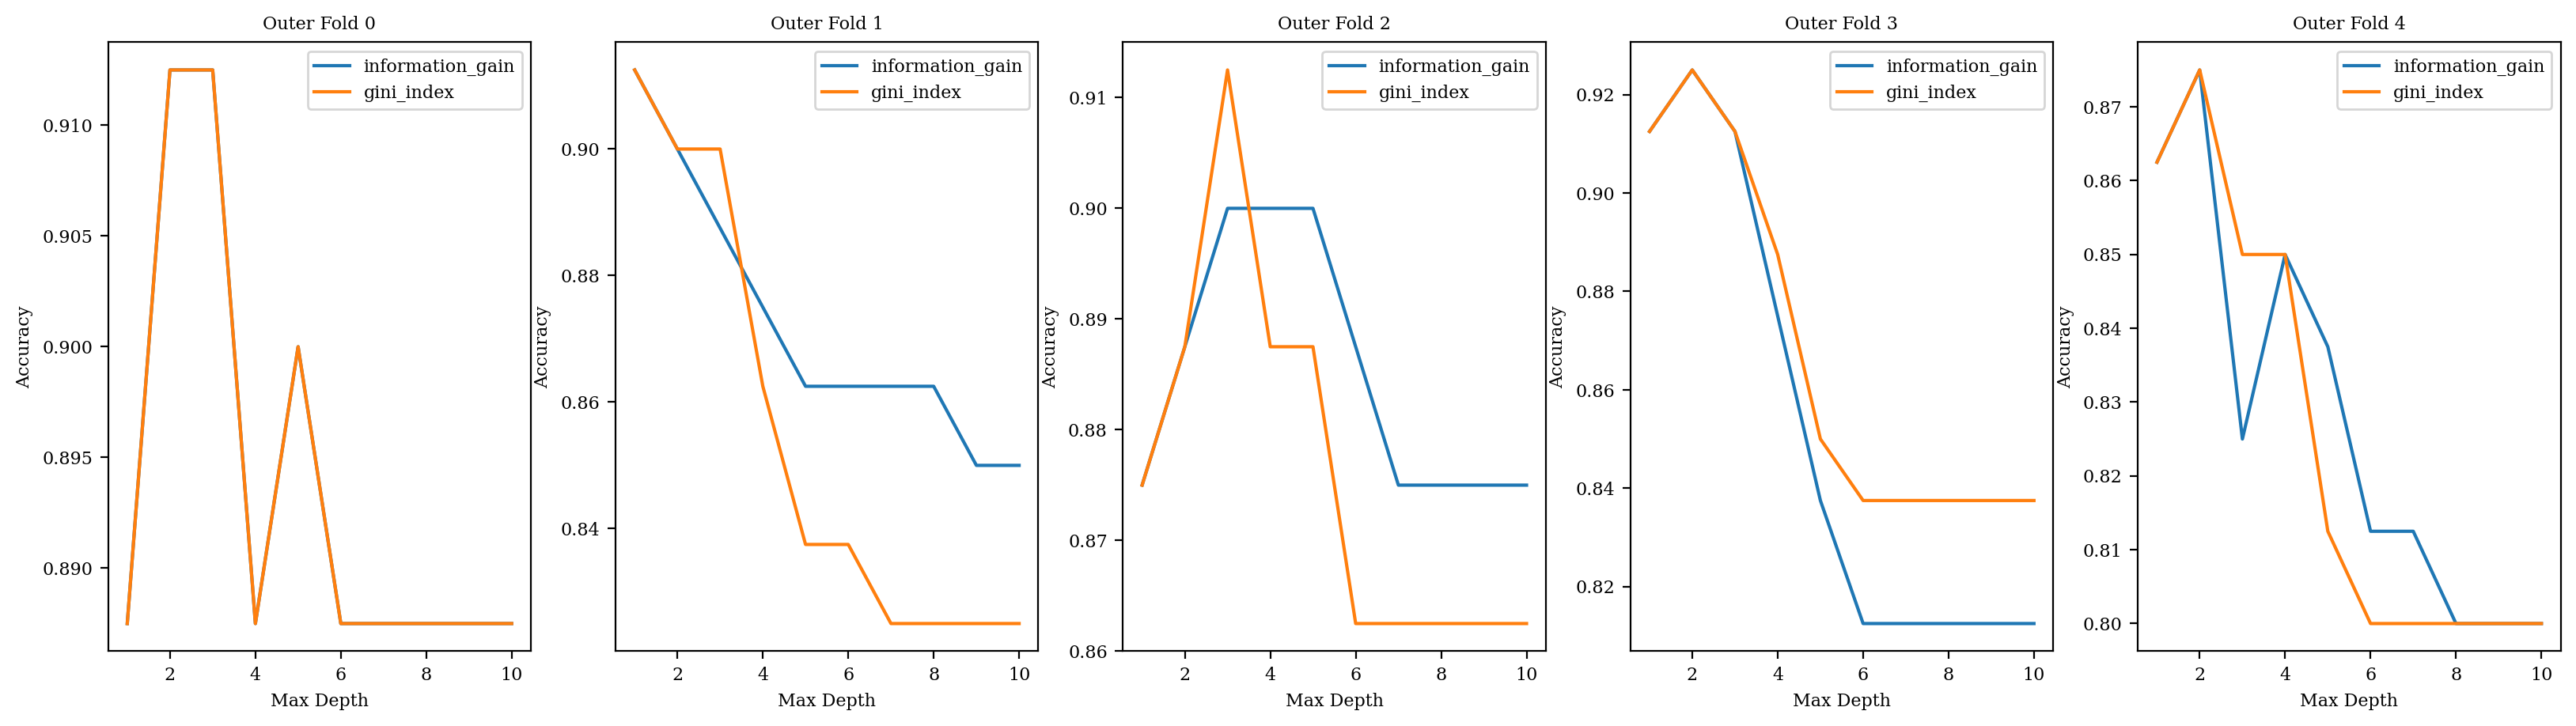

In [21]:
fig, ax = plt.subplots(1, num_outer_folds, figsize=(20, 5))
for i in range(num_outer_folds):
    outer_fold_results = overall_results[overall_results['outer_fold'] == i]
    for criterion in hyperparameters['criteria_values']:
        criterion_results = outer_fold_results[outer_fold_results['criterion'] == criterion]
        accuracies = criterion_results.groupby('max_depth')['val_accuracy'].mean()
        ax[i].plot(accuracies, label=criterion)
        ax[i].set_title(f'Outer Fold {i}')
        ax[i].set_xlabel('Max Depth')
        ax[i].set_ylabel('Accuracy')
        ax[i].legend()

#### Finding the optimal depth for the tree

In [44]:
best_depths = {c: [] for c in hyperparameters['criteria_values']}

for i in range(num_outer_folds):
    # print("Outer Fold: ", i)
    for criterion in hyperparameters['criteria_values']:
        outer_fold_df = overall_results.query(f'outer_fold == {i}')
        top_results = outer_fold_df.groupby(['max_depth', 'criterion']).mean()["val_accuracy"].sort_values(ascending=False)
        # print(top_results.head(3))
        best_depths[criterion].append(int(top_results.idxmax()[0]))

print("Best Depths: ", best_depths)

Best Depths:  {'information_gain': [2, 1, 3, 2, 2], 'gini_index': [2, 1, 3, 2, 2]}


In [46]:
print("Mean Best Depth: ")
for criterion in hyperparameters['criteria_values']:
    print(f"Criterion: {criterion}, Mean Best Depth: {np.mean(best_depths[criterion])}")

Mean Best Depth: 
Criterion: information_gain, Mean Best Depth: 2.0
Criterion: gini_index, Mean Best Depth: 2.0


**From the above graphs and data, we can conclude that 2 is the most optimal depth for the decision tree.**